In [1]:
import mujoco
import jax
import brax
import numpy as np
from jax import numpy as jp
from brax import actuator
from brax import geometry
from brax import kinematics
from brax.io import mjcf
from brax.base import System
from brax.generalized import pipeline
from brax.generalized import constraint
from brax.generalized import dynamics
from brax.generalized import integrator
from brax.generalized import mass
from brax.generalized.base import State

from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

import mediapy as media
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
rc('animation', html='jshtml')

%env MUJOCO_GL=egl

tpu
env: MUJOCO_GL=egl


In [ ]:
!lscpu

In [2]:
def visualize(axes, pos, alpha=1, slim=True):
    assert axes.shape == (3,)
    if slim == True:
        x_arm = jp.vstack([jp.zeros((1,3)), pos[:7]])
    else:
        x_arm = pos[:8] #dummy joint0
    title = ['X-Z view', 'X-Y view', 'Y-Z view']
    xlim = [(-1, 1), (-1, 1), (-1, 1)]
    ylim = [(-0.5, 1.5), (-1, 1), (-0.5, 1.5)]
    for i in range(3):
        axes[i].plot(x_arm[:, i//2], x_arm[:, 2-i%2], linewidth=5, label='Arm', alpha=alpha)
        axes[i].scatter(x_arm[slim:8, i//2], x_arm[slim:8, 2-i%2], s=150, c='orange', edgecolors='face', label='Joint')
        axes[i].grid()
        axes[i].set_title(title[i])
        axes[i].set_xlabel(title[i][0:1])
        axes[i].set_ylabel(title[i][2:3])
        axes[i].set_xlim(*xlim[i])
        axes[i].set_ylim(*ylim[i])
    legend = axes[-1].legend(['Arm'], loc='upper right', title='Components', bbox_to_anchor=(1.4, 1))
    axes[-1].add_artist(legend)

In [3]:
def sketch_render(xpos, save_name="figure/panda_slim.gif", slim=True, dt=0.002):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots()
    plt.xlim([-1, 1])
    plt.ylim([-0.5, 1.5])
    plt.axis ('equal')
    ax.grid()

    n = len(xpos)
    if slim == True:
        x_arm = jp.vstack([jp.zeros((1,3)), xpos[0, :7]])
    else:
        x_arm = xpos[0, :8] #dummy joint0
    line, = ax.plot(x_arm[:, 0], x_arm[:, 2], linewidth=5)
    scat = ax.scatter(x_arm[slim:, 0], x_arm[slim:, 2], s=150, c='orange', edgecolors='face')
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    plt.show()

    def init():
        return line,

    def animate(i):
        if slim == True:
            x_arm = jp.vstack([jp.zeros((1,3)), xpos[i, :7]])
        else:
            x_arm = xpos[i, :8] #dummy joint0
        line.set_data(x_arm[:, 0], x_arm[:, 2])
        scat.set_offsets(jp.vstack([x_arm[slim:, 0], x_arm[slim:, 2]]).T)
        time_text.set_text(time_template % (i*dt))
        return line, 

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=n, interval=20, blit=False, repeat=True)
    plt.close()
    anim.save(save_name)


# Panda

## Dummy Joint0

### Load Model

In [55]:
path = f'env/panda_slim_dummy_joint.xml'
# mj = mujoco.MjModel.from_xml_path(path)
# sys = mjcf.load_model(mj)
sys = mjcf.load(path)

Look up joints' velocity $qd$ and position $q$

In [5]:
sys.q_size(), sys.init_q.shape[0], sys.qd_size()

(9, 9, 9)

Look up links count and type

In [6]:
sys.num_links(), sys.link_types, len(sys.link_types)

(8, '21111111', 8)

In [7]:
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link0', -1, '2', [0, 1]),
 ('link1', 0, '1', [2]),
 ('link2', 1, '1', [3]),
 ('link3', 2, '1', [4]),
 ('link4', 3, '1', [5]),
 ('link5', 4, '1', [6]),
 ('link6', 5, '1', [7]),
 ('link7', 6, '1', [8])]

### Visualize the model

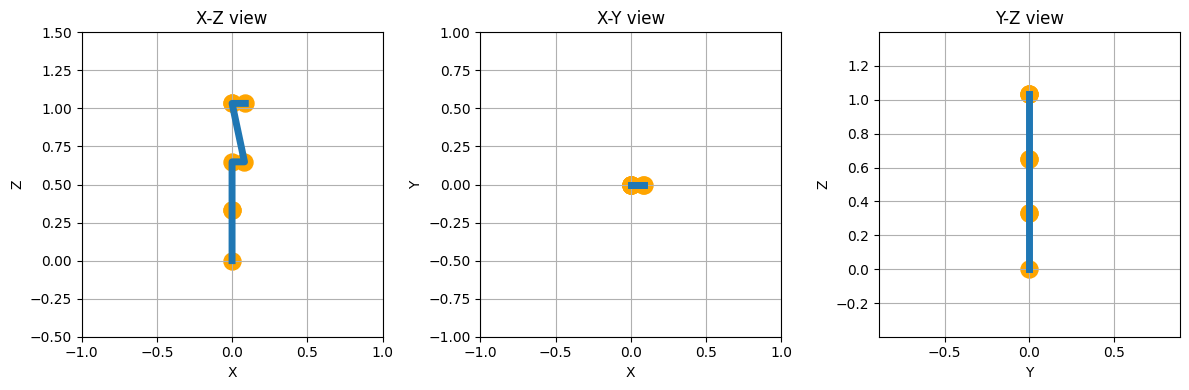

In [13]:
# Time: 4m50s
# q = sys.init_q
# qd = jp.zeros(sys.qd_size())
# x, xd = kinematics.forward(sys, q, qd)
# # state = jax.jit(pipeline.init)(sys, q, qd)

# # assert state.x.pos.all() == x.pos.all()

# _, axes = plt.subplots(1,3, figsize=(12, 4))
# plt.axis ('equal')
# visualize(axes, x.pos, alpha=1, slim=False)
# plt.tight_layout()

### Update Model

In [56]:
# Time: 41s
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])
q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

xpos = []
for i in range(1000):
    state = jax.jit(pipeline.step)(sys, state, act)
    xpos.append(state.x.pos)

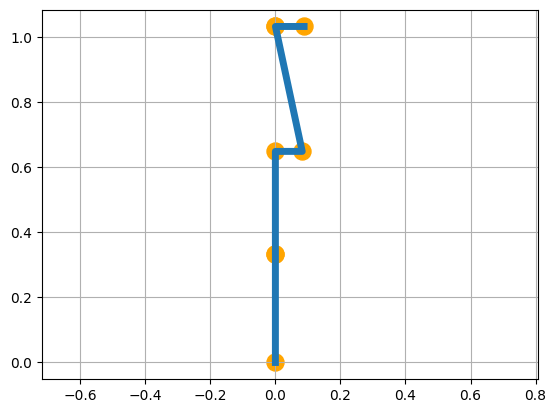

In [57]:
sketch_render(jp.array(xpos), save_name="figure/panda_slim_dummy_joint.mp4", slim=False, dt=sys.dt)
media.show_video(media.read_video("figure/panda_slim_dummy_joint.mp4"))

## Without dummy joint0

In [58]:
path = f'env/panda_slim.xml'
sys = mjcf.load(path)
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link1', -1, '1', [0]),
 ('link2', 0, '1', [1]),
 ('link3', 1, '1', [2]),
 ('link4', 2, '1', [3]),
 ('link5', 3, '1', [4]),
 ('link6', 4, '1', [5]),
 ('link7', 5, '1', [6])]

In [ ]:
# Time: 3m42s
# q = sys.init_q
# qd = jp.zeros(sys.qd_size())
# x, xd = kinematics.forward(sys, q, qd)

# _, axes = plt.subplots(1,3, figsize=(12, 4))
# plt.axis ('equal')
# visualize(axes, x.pos, alpha=1, slim=True)
# plt.tight_layout()

In [59]:
# Time 3m36s
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])
q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

xpos = []
for i in range(1000):
    state = jax.jit(pipeline.step)(sys, state, act)
    xpos.append(state.x.pos)

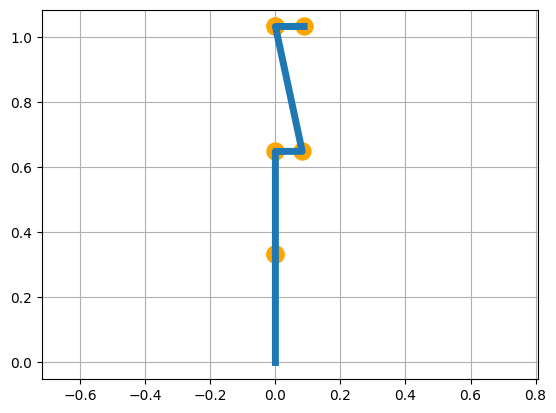

In [60]:
sketch_render(jp.array(xpos), save_name="figure/panda_slim.mp4", dt=sys.dt)
media.show_video(media.read_video("figure/panda_slim.mp4"))

# Whip+Panda

## W/ Dummy joint between `worldbody` and first `link`

In [11]:
path = f'env/whip_0_slim_dummy_joint.xml'
sys = mjcf.load(path)
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link0', -1, '2', [0, 1]),
 ('link1', 0, '1', [2]),
 ('link2', 1, '1', [3]),
 ('link3', 2, '1', [4]),
 ('link4', 3, '1', [5]),
 ('link5', 4, '1', [6]),
 ('link6', 5, '1', [7]),
 ('link7', 6, '1', [8]),
 ('B0', 7, '2', [9, 10]),
 ('B1', 8, '2', [11, 12]),
 ('B2', 9, '2', [13, 14]),
 ('B3', 10, '2', [15, 16]),
 ('B4', 11, '2', [17, 18]),
 ('B5', 12, '2', [19, 20]),
 ('B6', 13, '2', [21, 22]),
 ('B7', 14, '2', [23, 24]),
 ('B8', 15, '2', [25, 26]),
 ('B9', 16, '2', [27, 28]),
 ('B10', 17, '2', [29, 30]),
 ('B11', 18, '2', [31, 32]),
 ('B12', 19, '2', [33, 34]),
 ('B13', 20, '2', [35, 36]),
 ('B14', 21, '2', [37, 38]),
 ('target', -1, 'f', [39, 40, 41, 42, 43, 44])]

In [12]:
sys.actuator.ctrl_range

Array([[-2.8973,  2.8973],
       [-1.7628,  1.7628],
       [-2.8973,  2.8973],
       [-3.0718, -0.0698],
       [-2.8973,  2.8973],
       [-0.0175,  3.7525],
       [-2.8973,  2.8973]], dtype=float32)

In [13]:
# Time: 7min56s
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])
q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

In [14]:
# Time: 7min
state = jax.jit(pipeline.step)(sys, state, act)
state.x.pos

Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

## WO/ Dummy joint fuse worldbody and first link together